<a href="https://colab.research.google.com/github/DavidePanza/ml-jaguar-identification/blob/main/notebooks/03_modeling/dino2_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-metric-learning

from matplotlib import pyplot as plt
from collections import Counter
import os
import sys
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/gdrive')

!pip install wandb
import wandb

!pip install fiftyone -q
import fiftyone as fo
from fiftyone import ViewField as FO

from google.colab import userdata
wandb_api_key = userdata.get('wanddb_api')
try:
    wandb.login(key=userdata.get('wanddb_api'))
except:
    print("Please add WANDB_API_KEY to Colab secrets")
    wandb.login()

# import from gdino_utils
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
src_path = os.path.join(notebook_dir, 'src')
sys.path.append(src_path)
from dino2_utils import DINOv2ArcFace, JaguarDataset, JaguarDatasetProcessor, pad_to_square, setup_transform, get_embedding

## Overview

This notebook demonstrates the pipeline for fine-tuning a DINOv2 model on a dataset of jaguars using ArcFace loss. It begins by loading and processing the dataset. Key steps include:

1. **Dataset Loading and Preprocessing**: The dataset is loaded and processed using the `JaguarDatasetProcessor` class. Visualizations of the dataset's distribution are also generated.
2. **Model Setup**: The model architecture, optimizer, and hyperparameters (batch size, learning rate, etc.) are initialized.
3. **Training Loop**: The model is trained over multiple epochs, logging batch and epoch loss to Weights and Biases (wandb) for experiment tracking.
4. **Model Saving**: After training, the model is saved locally and uploaded to wandb as an artifact.


# Data Loading and Train/Test Split
This code loads a jaguar dataset using the FiftyOne library, and processes  jaguars images from the dataset, and optionally adds unknown jaguars. It then creates a label mapping for all jaguar identities and prints verification information, such as the number of identities and images in the train/test sets. The JaguarDatasetProcessor class handles the entire dataset processing pipeline.

In [ ]:
# Load the Dataset
image_dir = Path('path/to/your/images')
input_dir = Path('path/to/your/fo_dataset')

dataset = fo.Dataset.from_dir(
    dataset_dir=str(input_dir),
    dataset_type=fo.types.FiftyOneDataset,
    rel_dir=image_dir,
)

# Initialize the dataset processor
processor = JaguarDatasetProcessor()

# Process the dataset and display verification info
processor.process(dataset)

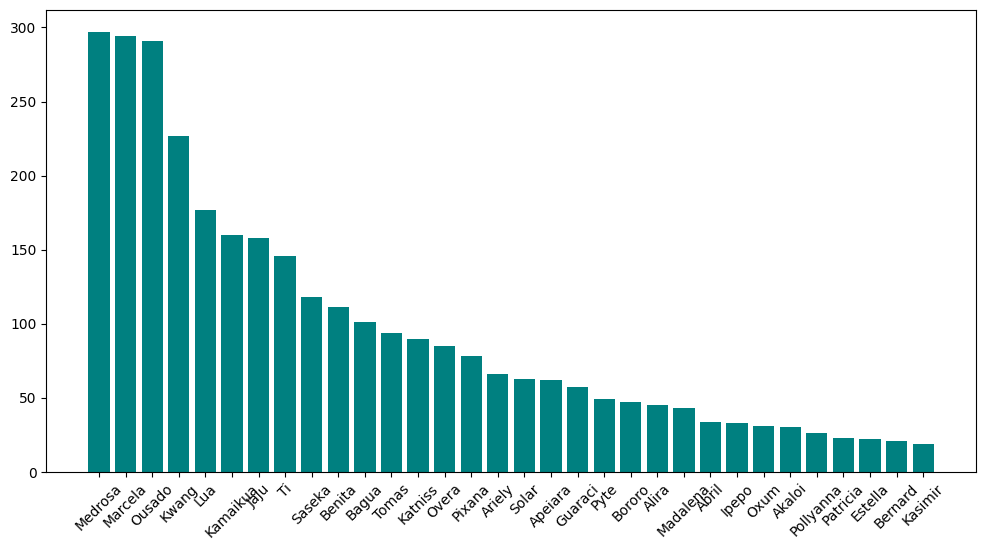

In [ ]:
# Visualise Number of Jaguars in the Train Split
label_counts = Counter(processor.train_labels_str)
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='teal')
plt.xticks(rotation=45)
plt.show()

### Model Setup and Training Configuration

In this section, we define and organize the key hyperparameters for training, initialize the Weights and Biases (wandb) for experiment tracking, set up the device (CUDA or CPU), initialize the model, and prepare the DataLoader. We use the `DINOv2ArcFace` model with an ArcFace loss function, and the dataset is processed and transformed before being fed into the model for training.

The main components include:
- **Hyperparameters**: Defining batch size, learning rate, embedding dimensions, and other settings.
- **wandb Initialization**: Used for tracking and logging the experiment.
- **Model and Optimizer**: The model is initialized and transferred to the selected device (GPU or CPU), and the optimizer is set up.
- **DataLoader**: The dataset is transformed, and a DataLoader is created to feed data during training.



In [ ]:
# Hyperparameters
NUM_JAGUARS = processor.num_jaguars  # Number of unique jaguars in your dataset
EMBEDDING_DIM = 512  # Size of the feature vector
MARGIN = 0.5  # Angular margin (critical for ArcFace)
SCALE = 64.0  # Scaling factor (helps convergence)
NUM_EPOCHS = 10
LR = 1e-5
BATCH_SIZE = 64

# Initialize Weights and Biases (wandb)
wandb.init(
    entity="jaguars",
    project="jaguars",
    config={
        "model": "facebook/dinov2-base",
        "loss": "ArcFace",
        "batch_size": BATCH_SIZE,
        "epochs": NUM_EPOCHS,
        "learning_rate": LR,
        "margin": MARGIN,
        "scale": SCALE,
        "dataset": "add here image type (segmented or cropped)"
    }
)

# Setup CUDA and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model and Optimizer
model = DINOv2ArcFace(usage="finetune", num_classes=NUM_JAGUARS, embedding_dim=EMBEDDING_DIM, margin=MARGIN, scale=SCALE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Prepare DataLoader
transform = setup_transform(use_padding=True)
dataset = JaguarDataset(
    image_paths=processor.train_image_paths,
    labels=processor.train_labels,
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model Finetuning

In [ ]:
# Training Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    # Loop through batches of data
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        _, loss = model(images, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate batch loss for the epoch
        epoch_loss += loss.item()

        # Print batch loss information
        print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        # Log batch-level metrics to wandb
        wandb.log({
            "train/batch_loss": loss.item(),
            "epoch": epoch,
            "batch": batch_idx,
        })

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(dataloader)

    # Log epoch-level metrics to wandb
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "epoch": epoch,
        "hyperparams/learning_rate": optimizer.param_groups[0]["lr"],
    })

    # Print epoch loss
    print(f"Epoch {epoch}, Avg Loss: {avg_epoch_loss:.4f}")


# Store the Finetuned Model

In [ ]:
# Save trained model
model_artifact = wandb.Artifact(
    name="trained_model",
    type="model",
    description="Fine-tuned model after training",
)

# Save model locally and add to artifact
model_path = "path/to/your/model.pth"
torch.save(model.state_dict(), model_path)
model_artifact.add_file(model_path)

# Log the artifact to wandb
wandb.log_artifact(model_artifact)

<Artifact trained_model>

In [ ]:
# Finish WandB run
wandb.finish()